# [Task 1] Named Entity Recognition  |  CRF  |  sklearn

Import Libraries.

In [1]:
import re
import os
import json
import numpy as np

import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
from collections import Counter
from pandas.io.json import json_normalize

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
%matplotlib inline
sns.set_style("dark")

## Util

Define class to read sentences one at a time.

In [3]:
class GetSentence(object):
    
    def __init__(self, data):
        self.i = 0
        self.id_list = np.unique(data['doc_id']).tolist()
        self.data = data
        
        agg_func = lambda x: [(w, t) for w, t in zip(x['word'].values.tolist(), x['obj'].values.tolist())]
        
        self.grouped_data = self.data.groupby('doc_id').apply(agg_func)
        self.sentences = [x for x in self.grouped_data]
        
    def get_next_sentence(self):
        try: 
            self.sentence = self.id_list[self.i]
            s = self.grouped_data[self.sentence]
            self.i += 1

            return s
        except:
            return None

Function to read json files.

In [4]:
def read_json(path):
    file = json.loads(open(path).read())
    
    return file

Function to extract words from text based on the indices.

In [5]:
def extract_word(begin, end, txt):
    return txt[begin:end]

In [6]:
base_dir = "../../data/AGAC_training-annotations/AGAC_training/json/"

## Prepare Data

BIO labelling of data.  

In [7]:
word_label_dict = {}

    
for f in os.listdir(base_dir):
    file = read_json(base_dir + f)
    # Extract the document ID from the file name
    doc_id = "".join(re.findall(r'\d', f))
    txt = file['text']


    for i in range(len(file['denotations'])):
        b = file['denotations'][i]['span']['begin']
        e = file['denotations'][i]['span']['end']
        word = extract_word(b, e, txt)
        word_split = word.split(' ')
        obj = file['denotations'][i]['obj']

        # If length of word (after splitting on " ") is more than 2
        # Put 'B/I' labels
        if len(word_split) == 2:
            b_word = word_split[0]
            i_word = word_split[-1]
            b_obj = "B-" + obj
            i_obj = "I-" + obj
            word_label_dict[i_word] = i_obj
            word_label_dict[b_word] = b_obj

        # If length of word (after splitting on " ") is equal to 1
        # Put a 'B' label
        else:
            b_word = word_split[0]
            b_obj = "B-" + obj

            word_label_dict[b_word] = b_obj

Clean the data and put the label 'O' where necessary.

In [8]:
final_list = []

for f in os.listdir(base_dir):
    file = read_json(base_dir + f)
    doc_id = "".join(re.findall(r'\d', f))
    txt = file['text']

    # Clean the text data
    txt = re.sub(r'\n', " ", txt)
    txt = re.sub(r'\.', "", txt)
    txt = re.sub(r',', "", txt)
    txt = re.sub(r':', "", txt)


    txt_split = txt.split(" ")

    # Put a label 'O' for words that do not appear
    # in word_label_dict
    for w in txt_split:
        if w in word_label_dict.keys():
            final_list.append((doc_id, w, word_label_dict[w]))
        else:
            final_list.append((doc_id, w, "O"))

In [9]:
data_df = pd.DataFrame(final_list, columns=['doc_id', 'word', 'obj'])

In [10]:
data_df.head()

,doc_id,word,obj
0,30442766,LZTR1,B-Gene
1,30442766,is,O
2,30442766,a,O
3,30442766,regulator,O
4,30442766,of,O


## EDA

### Count of words/obj per document.

In [11]:
data_df.groupby('doc_id').count().head()

,word,obj
doc_id,,
16371368,307,307
17435236,229,229
18031991,235,235
18594199,189,189
19338054,265,265


### Stats about the data.

In [12]:
data_df.describe()

,doc_id,word,obj
count,55808,55808,55808
unique,250,9744,25
top,28283687,of,O
freq,513,2206,35790


### Frequncy of different output labels.

Frequency with label 'O'.

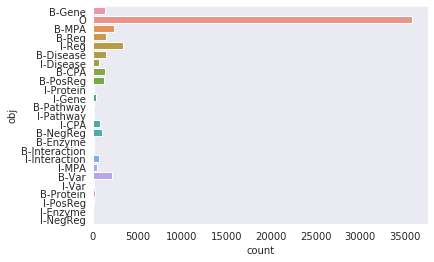

In [13]:
sns.countplot(y = "obj", data=data_df)

Frequency without label 'O'.

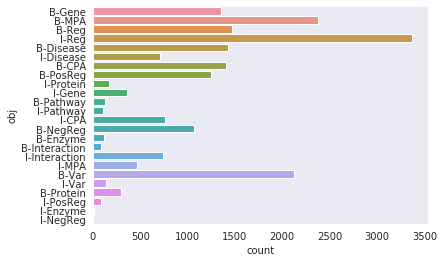

In [14]:
sns.countplot(y = "obj", data=data_df[data_df['obj'] != 'O'])

## Machine Learning - CRF

### Extract all the sentences.

In [15]:
getter = GetSentence(data_df)
sentences = getter.sentences

The following code was taken from [sklearn-crfsuite website](https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html)

In [16]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
        
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

### Convert the sentences into features in split it into train and test sets.

In [17]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

### Train the crf model.

In [18]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.15,
    max_iterations=200,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.15, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=200,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

### Classification Metrics

In [19]:
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred))

               precision    recall  f1-score   support

        B-CPA       1.00      1.00      1.00       444
    B-Disease       1.00      1.00      1.00       456
     B-Enzyme       1.00      1.00      1.00        46
       B-Gene       1.00      1.00      1.00       333
B-Interaction       1.00      1.00      1.00        23
        B-MPA       1.00      1.00      1.00       805
     B-NegReg       1.00      1.00      1.00       348
    B-Pathway       1.00      1.00      1.00        47
     B-PosReg       1.00      1.00      1.00       436
    B-Protein       1.00      1.00      1.00       109
        B-Reg       1.00      1.00      1.00       472
        B-Var       1.00      1.00      1.00       719
        I-CPA       1.00      1.00      1.00       260
    I-Disease       1.00      1.00      1.00       207
     I-Enzyme       1.00      1.00      1.00         3
       I-Gene       1.00      1.00      1.00       102
I-Interaction       1.00      1.00      1.00       258
        I

/home/akshaj/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/akshaj/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/akshaj/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Try out the model

In [20]:
t = "Effects of a leukemia-associated gain-of-function mutation of SHP-2 phosphatase on interleukin-3 signaling."
crf.predict_single(t.split(" "))

['B-Enzyme',
 'B-Enzyme',
 'B-Enzyme',
 'B-Enzyme',
 'B-Enzyme',
 'B-Enzyme',
 'B-Enzyme',
 'B-Enzyme',
 'B-Enzyme',
 'B-Enzyme',
 'B-Enzyme',
 'B-Enzyme']

CRF Model doesn't perform very well.